# House Price Prediction

## Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load and Preview Dataset

### Reading Csv File

In [46]:
df = pd.read_csv("lahore_housing_prices.csv")

### Display the first few rows

In [47]:
df.head()

,house_id,Type,Location,Area,Bath(s),Bedroom(s),Price
0,46326643,House,"DHA Defence, Lahore, Punjab",1 Kanal,6,5,75500000
1,46952582,House,"Bahria Orchard, Lahore, Punjab",8 Marla,5,5,25000000
2,47357581,House,"Paragon City, Lahore, Punjab",10 Marla,6,5,47000000
3,47397157,Flat,"Askari, Lahore, Punjab",10 Marla,3,3,28000000
4,43109993,House,"DHA Defence, Lahore, Punjab",8 Marla,5,4,43500000


## Data Exploration and Cleaning

### Dataset Shape

In [48]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (17169, 7)


### Count of Different Types of Houses

In [49]:
print("Count of different types of houses:\n", df.groupby("Type")["Type"].agg("count"))

Count of different types of houses:
 Type
Flat          1146
House        16017
Penthouse        4
Room             2
Name: Type, dtype: int64


### Drop house_id and Type Columns

In [50]:
df1 = df.drop(["house_id", "Type"], axis=1)

### Check for Null Values

In [51]:
print("Null values in each column:\n", df1.isnull().sum())

Null values in each column:
 Location      0
Area          0
Bath(s)       0
Bedroom(s)    0
Price         0
dtype: int64


### Clean 'Area' column

In [52]:
def clean_area(value):
    if 'Kanal' in value:
        numeric_value = float(value.split(' ')[0]) * 20
        return numeric_value
    elif 'Marla' in value:
        numeric_value = float(value.split(' ')[0])
        return numeric_value
    else:
        return None

df1["Marla"] = df1["Area"].apply(clean_area)
df1 = df1.drop("Area", axis=1)

### Outlier detection
#### Houses with Marla greater than 100:\n

In [53]:
print("Houses with Marla greater than 100:\n", df1[df1.Marla > 100])


Houses with Marla greater than 100:
                            Location  Bath(s)  Bedroom(s)      Price  Marla
1386     Model Town, Lahore, Punjab        6           6  560000000  120.0
3044     Model Town, Lahore, Punjab        6          10  650000000  160.0
3462            GOR, Lahore, Punjab        6           7  700000000  136.0
4484   Paragon City, Lahore, Punjab        6           7  350000000  160.0
5906    Garden Town, Lahore, Punjab        4           4  550000000  160.0
7012     Model Town, Lahore, Punjab        6           7  520000000  120.0
7556    Pine Avenue, Lahore, Punjab        6           5  170000000  182.0
8168   Paragon City, Lahore, Punjab        6           8  350000000  160.0
9672     Model Town, Lahore, Punjab        6           8  500000000  120.0
10847   Bahria Town, Lahore, Punjab        4           3   26000000  160.0
11536    Model Town, Lahore, Punjab        6           8  500000000  120.0
11641         Cantt, Lahore, Punjab        6           6  50000

#### Houses with Bedroom(s) greater than 6:

In [54]:
print("Houses with Bedroom(s) greater than 6:\n", df1[df1["Bedroom(s)"] > 6])

Houses with Bedroom(s) greater than 6:
                                        Location  Bath(s)  Bedroom(s)  \
90                  DHA Defence, Lahore, Punjab        6           7   
187                 DHA Defence, Lahore, Punjab        6           7   
221                Raiwind Road, Lahore, Punjab        6           7   
267                 DHA Defence, Lahore, Punjab        8           7   
270                 DHA Defence, Lahore, Punjab        8           7   
...                                         ...      ...         ...   
16936  Pak Arab Housing Society, Lahore, Punjab        6           8   
16994               Garden Town, Lahore, Punjab        6           8   
17017               DHA Defence, Lahore, Punjab        6           7   
17156               DHA Defence, Lahore, Punjab        6           7   
17164        PIA Housing Scheme, Lahore, Punjab        6           7   

           Price  Marla  
90     420000000   40.0  
187    150000000   40.0  
221     95000000 

#### Houses with Bath(s) greater than 6:

In [55]:
print("Houses with Bath(s) greater than 6:\n", df1[df1["Bath(s)"] > 6])

Houses with Bath(s) greater than 6:
                           Location  Bath(s)  Bedroom(s)      Price  Marla
70     DHA Defence, Lahore, Punjab        7           6   89500000   20.0
132    Harbanspura, Lahore, Punjab        7           6   60000000   20.0
267    DHA Defence, Lahore, Punjab        8           7   80000000   20.0
270    DHA Defence, Lahore, Punjab        8           7   77000000   20.0
503    DHA Defence, Lahore, Punjab        7           6  145000000   34.0
...                            ...      ...         ...        ...    ...
16795  Bahria Town, Lahore, Punjab        7           5   28000000   10.0
16856  DHA Defence, Lahore, Punjab        8           7   79000000   20.0
17057      GT Road, Lahore, Punjab        7           5   29000000   10.0
17154  DHA Defence, Lahore, Punjab        7           6  160000000   20.0
17166  DHA Defence, Lahore, Punjab        7           6  108500000   20.0

[116 rows x 5 columns]


## Feature Transformation

### Simplify 'Location' column

In [56]:
df1['Location'] = df1['Location'].apply(lambda x: x.split(',')[0].strip())

### Group rare locations into 'other'

In [57]:
location_stats = df1.groupby("Location")["Location"].agg('count').sort_values(ascending=False)
locations_less_than_10 = location_stats[location_stats <= 10]
df1['Location'] = df1['Location'].apply(lambda x: 'other' if x in locations_less_than_10 else x)

### Create dummy variables for 'Location'

In [58]:
location_dummies = pd.get_dummies(df1['Location']).astype(int)

df2 = pd.concat([df1, location_dummies], axis=1)
df2 = df2.drop("Location", axis=1)
df2

,Bath(s),Bedroom(s),Price,Marla,Al Noor Park Housing Society,Al Rehman Garden,Al-Hafiz Town,Al-Hamad Colony (AIT),Al-Hamd Park,Allama Iqbal Town,...,Taj Bagh Scheme,Tariq Gardens,Thokar Niaz Baig,Township,UET Housing Society,Valencia Housing Society,Vital Homes Housing Scheme,Walton Road,Wapda Town,other
0,6,5,75500000,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,5,25000000,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,5,47000000,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,28000000,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,4,43500000,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17164,6,7,49000000,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17165,4,3,28000000,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17166,7,6,108500000,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17167,6,5,75500000,20.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Test Split

### Prepare feature matrix and target vector

In [59]:
X = df2.drop("Price", axis=1)
y = df2['Price']

### Split the data

In [60]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

### Train Linear Regression model

In [61]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_score = linear_model.score(x_test, y_test)

### Train Lasso Regression model

In [62]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(x_train, y_train)
lasso_score = lasso_model.score(x_test, y_test)

C:\Users\rekoj\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.055e+18, tolerance: 4.000e+15
  model = cd_fast.enet_coordinate_descent(


### Train Ridge Regression model

In [63]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(x_train, y_train)
ridge_score = ridge_model.score(x_test, y_test)

### Train Decision Tree Regression model

In [64]:
tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train)
tree_score = tree_model.score(x_test, y_test)

# Print scores

In [65]:
print("Linear Regression score:", linear_score)
print("Lasso Regression score:", lasso_score)
print("Ridge Regression score:", ridge_score)
print("Decision Tree Regression score:", tree_score)

Linear Regression score: 0.7606185434886679
Lasso Regression score: 0.7606192027504026
Ridge Regression score: 0.7606377336793512
Decision Tree Regression score: 0.8385369659805926


# Accuracy Comparison

C:\Users\rekoj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


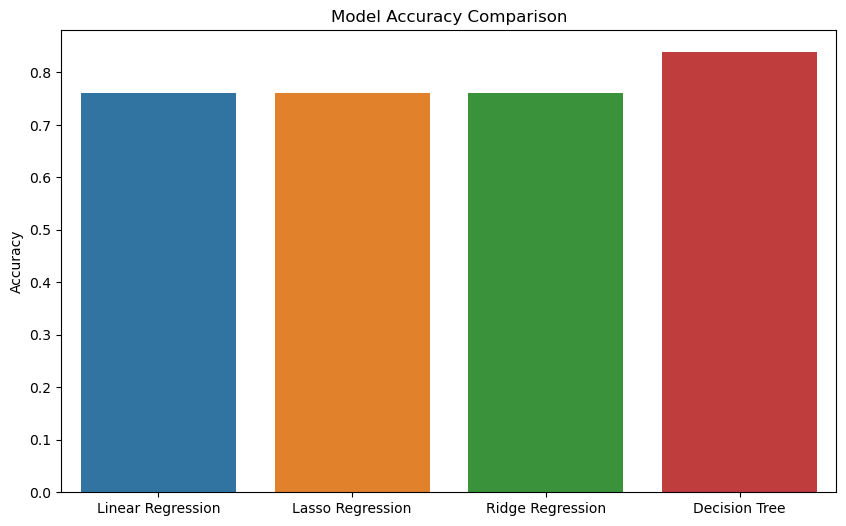

In [66]:
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree']
scores = [linear_score, lasso_score, ridge_score, tree_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=scores)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()

# Decision Tree Regression has the highest score

In [67]:
best_model = tree_model

# Define the predict_price function for Decision Tree Regression

In [68]:
def predict_price(location, marla, bath, bedroom):
    loc_index = np.where(X.columns == location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = bath
    x[1] = bedroom
    x[2] = marla

    if loc_index >= 0:
        x[loc_index] = 1

    predicted_price = best_model.predict([x])[0]
    return abs(predicted_price) if predicted_price < 0 else predicted_price

# Example prediction

In [69]:
print(f"Predicted price for a 10 Marla house with 4 baths and 4 bedrooms in DHA Defence: {predict_price('DHA Defence', 10, 4,4)}")

Predicted price for a 10 Marla house with 4 baths and 4 bedrooms in DHA Defence: 45865277.777777776


C:\Users\rekoj\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


# Save the Decision Tree model for web deployment

In [70]:
import pickle
with open('lahore_home_prices_model.pickle', 'wb') as f:
    pickle.dump(best_model, f)
    
import json
columns = {'data_columns': [col.lower() for col in X.columns]}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))